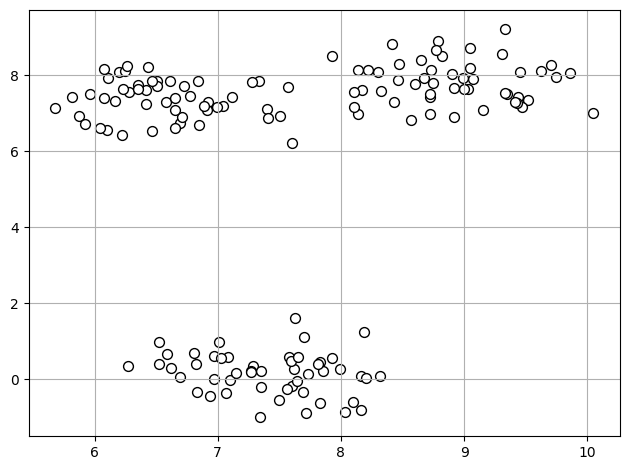

In [81]:
### K-means

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# 가우시안 정규분포를 따르는 가상의 cluster를 만들어주는 함수
X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True)

plt.scatter(X[:, 0], X[:, 1], 
            c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.tight_layout()
plt.show()

# 조금 더 랜덤한 결과를 보기 위해 random_state 설정은 제외

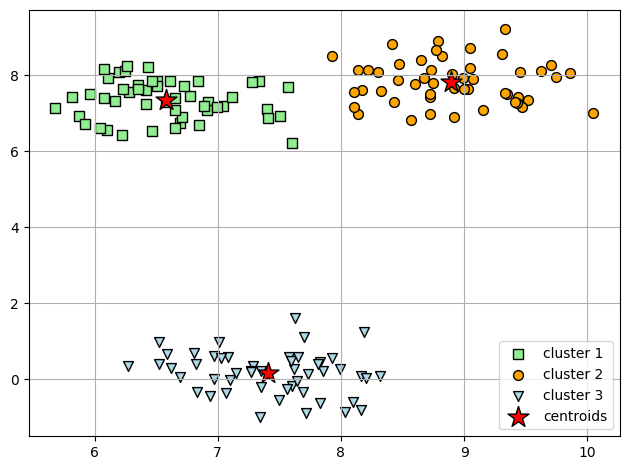

In [95]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, init='random', n_init=1,
            max_iter=300, tol=1e-04)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()



82.14806377733126


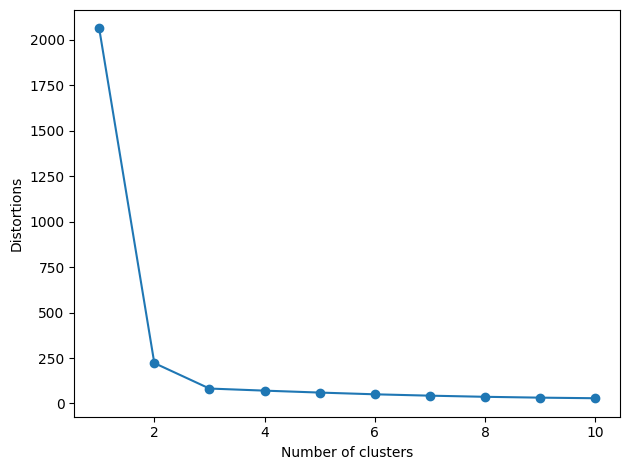

In [96]:
### 엘보우 방법을 사용한 클러스터 계수 최적화

print(km.inertia_)
# k-means 모델을 훈련시키면 자동으로 모델안에 이너셔를 저장하게 된다.
# k-means 모델은 cluster 개수를 사용자가 직접 할당해줘야되는 하이퍼파라미터 개념임.
# 하지만 실제 데이터셋에서는 데이터들의 분포가 많이 복잡해서 딱 눈으로 보고 cluster의 개수를 정하기가 쉽지 않음.
# 그래서 elbow 방법을 사용해 cluster의 개수를 늘려보고 이너셔가 수렴하는 지점이 있으면 그 cluster의 개수를 사용.

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.tight_layout()
plt.show()

# 결과를 보면 클러스터의 개수가 3개부터 어느정도 수렴하는걸 볼 수 있고, 이제 여기서 3~5정도까지 클러스터 개수를 늘려보면서
# 결과를 테스팅 하면서 최적의 클러스터 개수를 찾으면 됨.

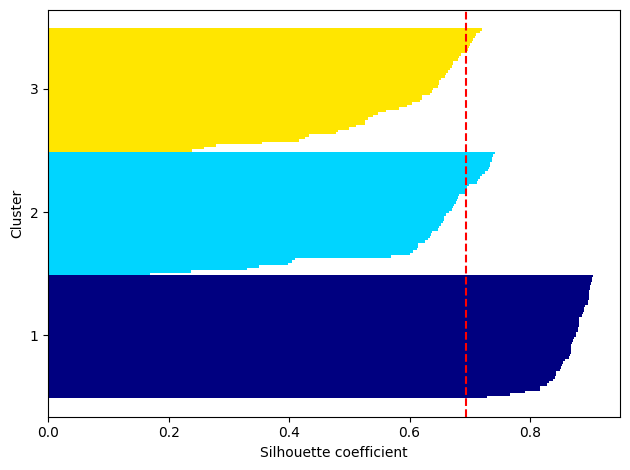

In [ ]:
### 실루엣 그래프

import numpy as np
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=3, init='k-means++', n_init=10,
            max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()


# 결과 보면 1번 클러스터는 0보다 아주 큰 폭으로 떨어져있고, 2번 3번 클러스터는 1번보다는 평균적으로 좀 떨어짐,
# 심지어 클러스터의 샘플중 최소값은 거의 0에 가깝게 나온 샘플도 있어서 군집이 잘못 되었다고 볼 수 있긴 하지만,
# 데이터 분포가 저래서 어쩔수 없는 경우도 있음. (이게 최선일수도 있다는거임..)

In [101]:
### 병합 계층 군집을 이용하여 상향식으로 데이터 묶기

import pandas as pd
import numpy as np

np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5']

X = np.random.sample([5, 3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_1,6.964692,2.861393,2.268515
ID_2,5.513148,7.194690,4.231065
ID_3,9.807642,6.848297,4.809319
ID_4,3.921175,3.431780,7.290497
ID_5,4.385722,0.596779,3.980443


In [ ]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels, index=labels)
row_dist
# 위에서 만들었던 샘플들의 거리행렬로 만들 수 있음.

from scipy.cluster.hierarchy import linkage

#row_cluster = linkage(row_dist, method='complete', metric='euclidean') 잘못된 예

#row_cluster = linkage(pdist(df, metric='euclidean'), method='complete')
row_clusters = linkage(df.values, method='complete', metric='euclidean')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


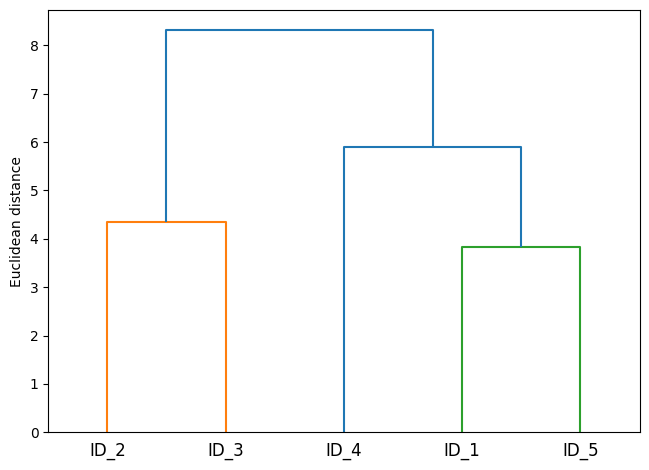

In [ ]:
### 연결 행렬을 덴드로그램으로 나타내기

from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# 결과를 보면 (2번 샘플 / 3번 샘플) 과 (1번 샘플 / 5번 샘플)이 제일 가까운 클러스터임을 알 수 있음.

# 병합 계층 군집을 쓰는 이유?
# EDA를 할 때, 데이터가 어떤식으로 합쳐지는지 시각화를 할 수 있어서, K-Means 알고리즘을 돌리기전에 미리 한번 돌려봐서
# 데이터가 합쳐지는걸 바탕으로 대충 몇개의 클러스터를 쓰면 되는가을 알 수 있어서 좋다.
# 이 알고리즘으로 학습을 하는게 아님! 분석용 느낌이 강함.

C:\Users\조승현\AppData\Local\Temp\ipykernel_10428\786606799.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_xticklabels([''] + list(df_rowclust.columns))
C:\Users\조승현\AppData\Local\Temp\ipykernel_10428\786606799.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_yticklabels([''] + list(df_rowclust.index))


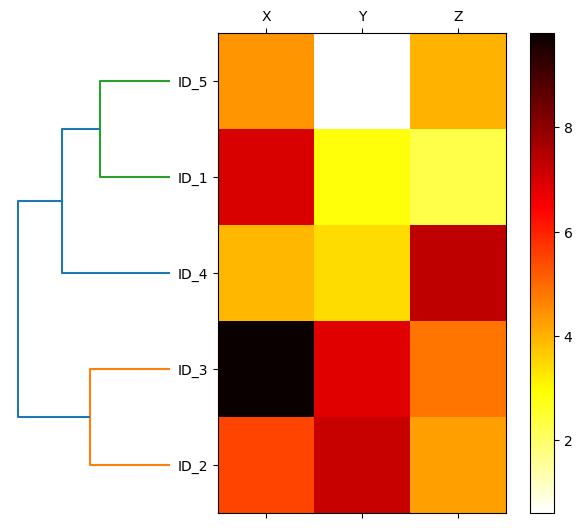

In [ ]:
### 히트맵에 덴드로그램 연결

fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

row_dendr = dendrogram(row_clusters, orientation='left')

df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

for i in axd.spines.values():
    i.set_visible(False)

axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

# 히트맵을 굳이 쓰는 이유?
# 거리행렬을 숫자로 표현하면 사용자가 눈으로 파악하기에 데이터의 구조나, 패턴을 한눈에 파악하기 쉽지 않은 경우가 많은데,
# 히트맵을 사용하여 행렬에 있는 숫자를 색깔로 만들어서 한눈에 데이터를 보기 쉽게 만들 수 있음.

In [118]:
### 병합 군집을 사이킷런으로 적용해보기

from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' %(labels))

# 클러스터를 3개로 표현해서 위에서 본 히트맵의 결과와 같다라는걸 볼 수 있음.
# 1 / 5번 샘플은 1번 레이블
# 2 / 3번 샘플은 0번 레이블
# 4번 샘플은 독립적으로 2번 레이블


# 클러스터를 2개로 했을때
ac = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' %(labels))

클러스터 레이블: [1 0 0 2 1]
클러스터 레이블: [0 1 1 0 0]


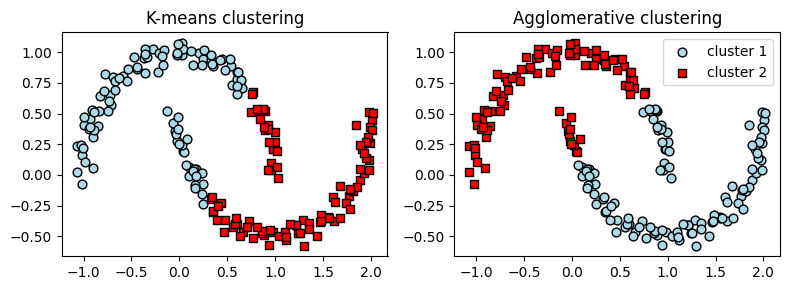

In [ ]:
### 반달 모양의 데이터셋에서 K-Means 알고리즘과 병합 군집 알고리즘 적용해보기

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
#plt.scatter(X[:, 0], X[:, 1])
#plt.tight_layout()
#plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)

ac = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)

ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

# 결과를 보면 k-means와 병합 군집 알고리즘 모두 반달모양을 제대로 구분하지 못하고 있음.
# 근데 사실 병합 군집은 기준을 complete가 아닌 single로 바꾸면 제대로 구분함 ㅋ
# 단일 연결일때 chain 현상이 일어나기 때문에 제대로 구분할 수 있지만, 평균적인 상황에서는 별로 좋지 않긴함.


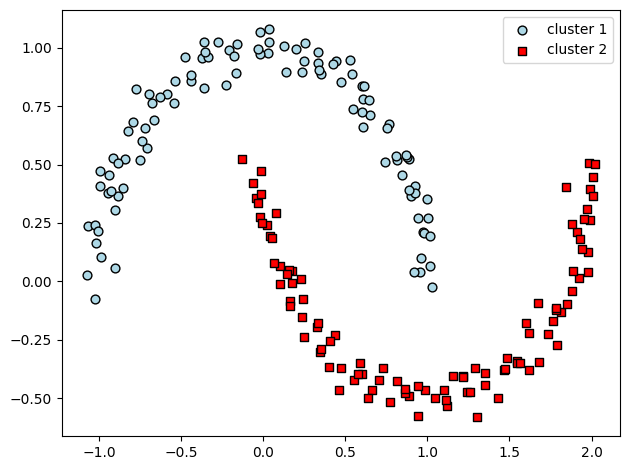

In [ ]:
### DBSCAN 알고리즘을 이용해서 반달 모양 데이터를 구분해보기

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)

plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

# DBSCAN 알고리즘은 아주 잘 분류하는걸 볼 수있음.
# K-Means는 클러스터를 원형으로 가정하지만 DBSCAN 알고리즘은 데이터의 분포를 원형으로 가정하지 않는다는점임.
# 